We start by importing common libraries

In [101]:
# load common libraries
import numpy as np                 # maths
import matplotlib.pyplot as plt    # plotting
import pandas as pd                # data manipulation
from tqdm import tqdm              # loading bar
from time import perf_counter      # timer

We open the full dataset obtained by merging the "order_products__prior.csv" dataset with all the other identifiers datasets (products, departments, aisles).

In [28]:
df = pd.read_csv("~/Downloads/finaldf.csv")

Let's create and a 10% subsample to finetune our models and have lower running times.

In [29]:
import pandas as pd
import numpy as np

# Set the desired percentage to subsample
percentage = 0.1

# Get unique user IDs
unique_user_ids = df['user_id'].unique()

# Randomly select user IDs
selected_user_ids = np.random.choice(unique_user_ids, size=int(len(unique_user_ids) * percentage), replace=False)

# Filter the DataFrame based on the selected user IDs
df_subsample = df[df['user_id'].isin(selected_user_ids)]

# Save the subsampled DataFrame as a new CSV file
df_subsample.to_csv("~/Downloads/subsample_finaldf.csv", index=False)


Let's explore the dataset

In [102]:
#df_subsample = pd.read_csv("~/Downloads/subsample_finaldf.csv")

df_subsample = pd.read_csv("~/Downloads/finaldf.csv")

products = pd.read_csv("~/Downloads/products.csv").set_index('product_id')

In [103]:
print(df_subsample)

          order_id  user_id eval_set  order_number  order_dow  \
0          2539329        1    prior             1          2   
1          2398795        1    prior             2          3   
2           473747        1    prior             3          3   
3          2254736        1    prior             4          4   
4           431534        1    prior             5          4   
...            ...      ...      ...           ...        ...   
29157079   2825867   151893    prior             1          2   
29157080   1286129   151893    prior             5          6   
29157081   1413525   151893    prior             9          6   
29157082   2734472   151893    prior            23          2   
29157083   3114310   152174    prior            16          6   

          order_hour_of_day  days_since_prior_order  product_id  \
0                         8                     NaN         196   
1                         7                    15.0         196   
2                 

First data construction step, we group the observations by customers and create a new dataset at the user_id level. This new dataset has 4 variables: user_id, products_sentence(a string made up of all products bought by a customer listed one after the other), product_id_list and aisle_id_list (these two are lists of the products_id and aisles_id for all the products bought by a single customer, respectively).

In [104]:
# Group the dataset by user_id and aggregate product names into a single string
grouped_df = df_subsample.groupby('user_id')['product_id'].apply(lambda x: ' '.join(products.loc[x, 'product_name']))

# Create a new DataFrame with user_id, products_sentence, and product_id_list columns
reshaped_df = pd.DataFrame({
    'user_id': grouped_df.index,
    'products_sentence': grouped_df.values,
    'product_id_list': df_subsample.groupby('user_id')['product_id'].apply(list),
    'aisle_id_list': df_subsample.groupby('user_id')['aisle_id'].apply(list)
})

# Display the reshaped DataFrame
print(reshaped_df.head())

         user_id                                  products_sentence  \
user_id                                                               
1              1  Soda Soda Soda Soda Soda Soda Soda Soda Soda S...   
2              2  Organic Just Concord Grape Juice Good Belly Pr...   
3              3  China Green Tips Green Tea Electrolyte Water E...   
4              4  Diet Caffeine Free Naturally Flavored Lemon Li...   
5              5  Semi-Soft Cheese, Ripened Plain Whole Milk Yog...   

                                           product_id_list  \
user_id                                                      
1        [196, 196, 196, 196, 196, 196, 196, 196, 196, ...   
2        [35917, 34688, 34688, 34688, 20084, 27413, 315...   
3        [1005, 23650, 23650, 17668, 17668, 17668, 1766...   
4        [17769, 25146, 7350, 26576, 2707, 7160, 37646,...   
5        [5999, 24535, 24535, 24535, 43693, 43693, 4369...   

                                             aisle_id_list  
user_i

In [105]:
print(reshaped_df.shape)

(206126, 4)


It's time to preprocess the sentences: lowercase, replace numbers, get rid of punctuation and symbols, tokenize, remove single character words and remove words that appear only once among all words for all customers.

In [106]:
## Preprocess data
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

# Make the products_sentence column lowercase and replace numbers with #s
reshaped_df['products_sentence'] = reshaped_df['products_sentence'].str.lower()
reshaped_df['products_sentence'] = reshaped_df['products_sentence'].str.replace(r'\d', '#s')

# Remove punctuation, extra spaces, and symbols
tokenizer = RegexpTokenizer(r'\w+')
reshaped_df['cleaned_sentence'] = reshaped_df['products_sentence'].apply(lambda x: tokenizer.tokenize(x))
reshaped_df['cleaned_sentence'] = reshaped_df['cleaned_sentence'].apply(lambda x: [word for word in x if word not in string.punctuation and len(word) > 1])

# Count word frequencies
word_freq = {}
for sentence in reshaped_df['cleaned_sentence'].values:
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

# Remove words that appear only once
reshaped_df['cleaned_sentence'] = reshaped_df['cleaned_sentence'].apply(lambda x: [word for word in x if word_freq[word] > 1])

C:\Users\UTENTE\AppData\Local\Temp\ipykernel_18752\1378274456.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  reshaped_df['products_sentence'] = reshaped_df['products_sentence'].str.replace(r'\d', '#s')


In [107]:
print(reshaped_df)

         user_id                                  products_sentence  \
user_id                                                               
1              1  soda soda soda soda soda soda soda soda soda s...   
2              2  organic just concord grape juice good belly pr...   
3              3  china green tips green tea electrolyte water e...   
4              4  diet caffeine free naturally flavored lemon li...   
5              5  semi-soft cheese, ripened plain whole milk yog...   
...          ...                                                ...   
206205    206205  orange calcium & vitamin d pulp free vanilla p...   
206206    206206  club soda ginger beer premium ginger ale premi...   
206207    206207  ruby red grapefruit juice ruby red grapefruit ...   
206208    206208  appley ever after organic juice drink organic ...   
206209    206209  diet pepsi pack diet pepsi pack diet pepsi pac...   

                                           product_id_list  \
user_id       

Truncate sentence lenght to 1500 to speed up the running time.

In [108]:
# Truncate sentences longer than 1500 words
reshaped_df['cleaned_sentence'] = reshaped_df['cleaned_sentence'].apply(lambda x: x[:1500])

The time has come for Word2Vec! We use the preprocessed sentences from before, window is as big the longest sentence (products are listed randomly, so we want to capture the relationship between any two words in the sentences), minimum count is 2 and we get vectors with 100 dimensions as output.

In [109]:
import gensim
from gensim.models import Word2Vec
np.random.seed(42)

# Find the longest sentence in the dataset
longest = max(reshaped_df['cleaned_sentence'].apply(len))
print(longest)

# Train Word2Vec model
model = gensim.models.Word2Vec(sentences=reshaped_df['cleaned_sentence'], vector_size=100, window=longest, min_count=2, workers=4)

# Create vectors for the sentences of each customer
reshaped_df['products_vector'] = reshaped_df['cleaned_sentence'].apply(lambda x: [model.wv[word] for word in x if word in model.wv])

1500


In [110]:
# Display the modified DataFrame
print(reshaped_df.head())

         user_id                                  products_sentence  \
user_id                                                               
1              1  soda soda soda soda soda soda soda soda soda s...   
2              2  organic just concord grape juice good belly pr...   
3              3  china green tips green tea electrolyte water e...   
4              4  diet caffeine free naturally flavored lemon li...   
5              5  semi-soft cheese, ripened plain whole milk yog...   

                                           product_id_list  \
user_id                                                      
1        [196, 196, 196, 196, 196, 196, 196, 196, 196, ...   
2        [35917, 34688, 34688, 34688, 20084, 27413, 315...   
3        [1005, 23650, 23650, 17668, 17668, 17668, 1766...   
4        [17769, 25146, 7350, 26576, 2707, 7160, 37646,...   
5        [5999, 24535, 24535, 24535, 43693, 43693, 4369...   

                                             aisle_id_list  \
user_

In [111]:
# Count the number of dropped observations
num_dropped = reshaped_df['products_vector'].apply(lambda x: len(x) == 0).sum()

# Drop observations with empty lists
reshaped_df = reshaped_df[reshaped_df['products_vector'].apply(lambda x: len(x) > 0)].copy()

# Reset the index if needed
reshaped_df.reset_index(drop=True, inplace=True)

# Print the number of dropped observations
print(f"Number of dropped observations: {num_dropped}")

# Display the resulting dataframe
print(reshaped_df)

Number of dropped observations: 0
        user_id                                  products_sentence  \
0             1  soda soda soda soda soda soda soda soda soda s...   
1             2  organic just concord grape juice good belly pr...   
2             3  china green tips green tea electrolyte water e...   
3             4  diet caffeine free naturally flavored lemon li...   
4             5  semi-soft cheese, ripened plain whole milk yog...   
...         ...                                                ...   
206121   206205  orange calcium & vitamin d pulp free vanilla p...   
206122   206206  club soda ginger beer premium ginger ale premi...   
206123   206207  ruby red grapefruit juice ruby red grapefruit ...   
206124   206208  appley ever after organic juice drink organic ...   
206125   206209  diet pepsi pack diet pepsi pack diet pepsi pac...   

                                          product_id_list  \
0       [196, 196, 196, 196, 196, 196, 196, 196, 196, ...   
1  

In [112]:
# Remove outer square brackets from each list
reshaped_df['products_vector'] = reshaped_df['products_vector'].apply(lambda x: x[0])

In [113]:
print(reshaped_df)

        user_id                                  products_sentence  \
0             1  soda soda soda soda soda soda soda soda soda s...   
1             2  organic just concord grape juice good belly pr...   
2             3  china green tips green tea electrolyte water e...   
3             4  diet caffeine free naturally flavored lemon li...   
4             5  semi-soft cheese, ripened plain whole milk yog...   
...         ...                                                ...   
206121   206205  orange calcium & vitamin d pulp free vanilla p...   
206122   206206  club soda ginger beer premium ginger ale premi...   
206123   206207  ruby red grapefruit juice ruby red grapefruit ...   
206124   206208  appley ever after organic juice drink organic ...   
206125   206209  diet pepsi pack diet pepsi pack diet pepsi pac...   

                                          product_id_list  \
0       [196, 196, 196, 196, 196, 196, 196, 196, 196, ...   
1       [35917, 34688, 34688, 34688, 

We start the analysis: Principal Component Analysis

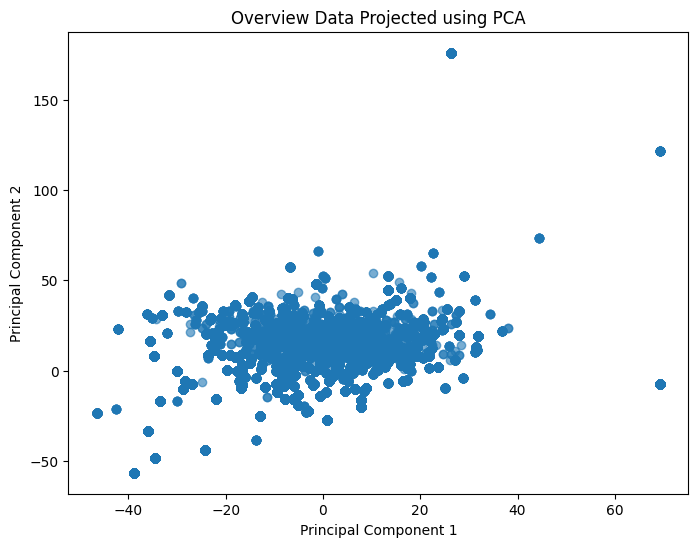

In [129]:
# import PCA decomposition class from sklearn
from sklearn.decomposition import PCA

# we did exactly this in the lecture notebook
# Step 1: Data preprocessing
# Convert the word2vec products to numpy array
products_features = np.array(reshaped_df['products_vector'].tolist())

# Step 2, 3, 4
# Set up PCA object
pca = PCA(n_components=2)  # Set the desired number of components

# Perform covariance matrix computation and eigendecomposition
products_pca = pca.fit_transform(products_features)

# Step 5: Plotting the projected data
plt.figure(figsize=(8, 6))
plt.scatter(products_pca[:, 0], products_pca[:, 1], alpha=0.6)
plt.title('Overview Data Projected using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

[[  0.46291035   5.841165     3.2215393  ...   8.839362   -10.146623
   -0.7094625 ]
 [ -2.3336372  -11.112221     3.6775362  ...  -0.553588     2.6582015
   15.318383  ]
 [  2.0044851   -3.0103805    2.7343967  ...  -1.9084743   12.727624
    0.8362179 ]
 ...
 [ -3.192595    -3.0697057   -1.5615543  ...   3.7864897    4.4721856
   10.056372  ]
 [ -0.7140364    5.263947   -13.696798   ...   5.4758854    5.2624674
    2.968605  ]
 [  3.9517097   -1.0230101    3.7703884  ...  -4.9085116   -2.4056737
   -7.414749  ]]
[0.17582289 0.07499575]


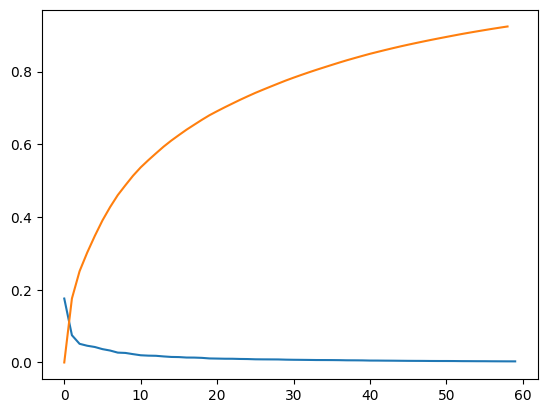

In [130]:
# Set up PCA object with the desired number of components
pca = PCA(n_components=60)  # Set the desired number of components
# fit transform one_hot_overview encodings
labels_pca = pca.fit(products_features)
print(products_features)
# get explained variance ratio from object, store it in a list
powers = pca.explained_variance_ratio_

print(powers[:2])
plt.plot(powers)
plt.plot([np.sum(powers[:i]) for i in range(len(powers)-1)])

We find the number of components that explain 80% of the variance in the data

In [131]:
# your code answer here
cumulative_variance_ratio = np.cumsum(powers)  # Compute cumulative explained variance ratio
components_needed = np.argmax(cumulative_variance_ratio >= 0.8) + 1  # Find the index where cumulative variance exceeds 80%
print(f"Number of principal components needed to explain 80% of variance: {components_needed}")

Number of principal components needed to explain 80% of variance: 33


In [132]:
n_dims = components_needed # Number of dimensions to retain based on 80% rule
pca = PCA(n_components=n_dims)  # Initialize PCA object with the desired number of dimensions
labels_pca = pca.fit_transform(np.array(reshaped_df['products_vector'].tolist()))  # Convert one_hot_overview to numerical array and then fit and transform using PCA
reshaped_df["products_pca"] = labels_pca.tolist()  # Add the transformed data to a new column 'overview_pca'

We cluster observations using k-means

In [150]:
# import KMeans class
from sklearn.cluster import KMeans

# Perform K-means clustering
k = 8
kmeans = KMeans(n_clusters=k)
kmeans.fit(reshaped_df["products_pca"].tolist())

# Get the predicted clusters
y_preds = kmeans.predict(reshaped_df["products_pca"].tolist())

# Add the predicted clusters to the dataframe
reshaped_df["cluster_kmeans"] = y_preds

# Print elements of cluster 0
cluster_0_elements = reshaped_df[reshaped_df["cluster_kmeans"] == 0]
print(cluster_0_elements)

c:\Users\UTENTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


        user_id                                  products_sentence  \
0             1  soda soda soda soda soda soda soda soda soda s...   
3             4  diet caffeine free naturally flavored lemon li...   
14           15  soda soda soda soda soda cola cans diet diet d...   
16           17  cola cola cola cola cola cola cola cola cola c...   
18           19  soda soda soda coke zero diet soda coke zero d...   
...         ...                                                ...   
206108   206192  lemonade lemonade lemonade lemonade almond bre...   
206115   206199  zero soda zero soda zero soda zero soda zero s...   
206117   206201  soda canned aranciata orange ginger ale ginger...   
206122   206206  club soda ginger beer premium ginger ale premi...   
206125   206209  diet pepsi pack diet pepsi pack diet pepsi pac...   

                                          product_id_list  \
0       [196, 196, 196, 196, 196, 196, 196, 196, 196, ...   
3       [17769, 25146, 7350, 26576, 2

c:\Users\UTENTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\UTENTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\UTENTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\UTENTE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

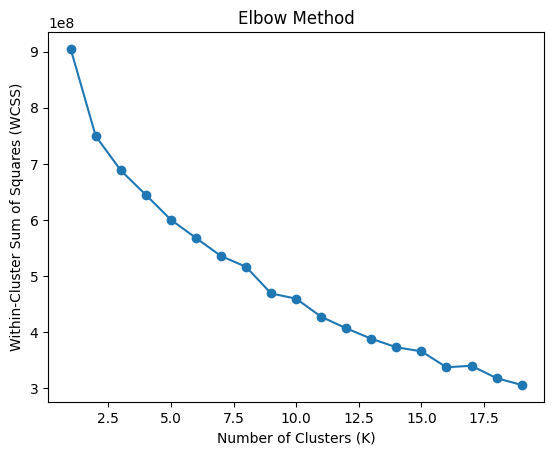

In [144]:
# Perform K-means clustering for different values of K
wcss = []
k_values = range(1, 20)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reshaped_df["products_pca"].tolist())
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

Now we cluster using GMM

In [151]:
# import GMM class
from sklearn.mixture import GaussianMixture

# Perform K-means clustering
gmm = GaussianMixture(8)
gmm.fit(reshaped_df["products_pca"].tolist())

predicted_gmm = gmm.predict(reshaped_df["products_pca"].tolist())

# Add the predicted clusters to the dataframe
reshaped_df["cluster_gmm"] = predicted_gmm

# Print elements of cluster 0
cluster_0_elements = reshaped_df[reshaped_df["cluster_gmm"] == 0]
print(cluster_0_elements)

        user_id                                  products_sentence  \
9            10  goat cheese log goat cheese log goat cheese lo...   
10           11  premium indian tonic water premium indian toni...   
32           33  pure sparkling water sparkling natural mineral...   
44           45  premium indian tonic water mango flavor probio...   
49           50  premium indian tonic water premium indian toni...   
...         ...                                                ...   
206088   206172  pure leaf tea unsweetened pure leaf tea unswee...   
206099   206183  premium indian tonic water premium indian toni...   
206100   206184  #s#s#s% raw coconut water unsweetened almondmi...   
206111   206195  limonata sparkling lemon beverage limonata spa...   
206121   206205  orange calcium & vitamin d pulp free vanilla p...   

                                          product_id_list  \
9       [47526, 47526, 47526, 47526, 40604, 40604, 406...   
10      [27959, 27959, 27959, 27959, 

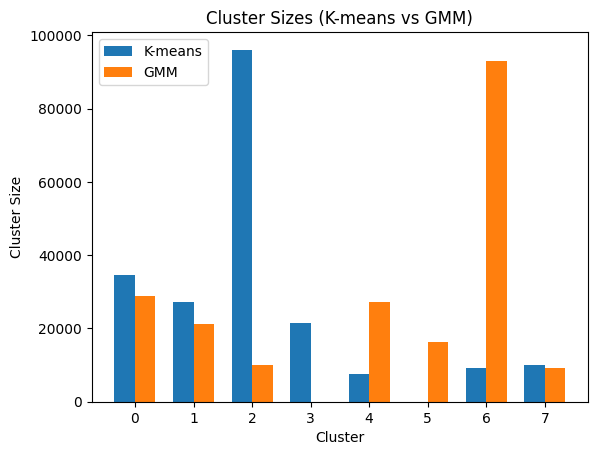

In [152]:
import numpy as np
import matplotlib.pyplot as plt

# Get the cluster sizes for K-means
kmeans_cluster_sizes = reshaped_df["cluster_kmeans"].value_counts().sort_index()

# Get the cluster sizes for GMM
gmm_cluster_sizes = reshaped_df["cluster_gmm"].value_counts().sort_index()

# Set the x-axis labels
x_labels = np.arange(len(kmeans_cluster_sizes))

# Set the bar width
bar_width = 0.35

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the K-means cluster sizes
ax.bar(x_labels - bar_width/2, kmeans_cluster_sizes, bar_width, label='K-means')

# Plot the GMM cluster sizes
ax.bar(x_labels + bar_width/2, gmm_cluster_sizes, bar_width, label='GMM')

# Set the labels, title, and legend
ax.set_xlabel('Cluster')
ax.set_ylabel('Cluster Size')
ax.set_title('Cluster Sizes (K-means vs GMM)')
ax.legend()

# Set the x-axis tick labels
ax.set_xticks(x_labels)
ax.set_xticklabels(x_labels)

# Show the plot
plt.show()


In [153]:
print(reshaped_df)

        user_id                                  products_sentence  \
0             1  soda soda soda soda soda soda soda soda soda s...   
1             2  organic just concord grape juice good belly pr...   
2             3  china green tips green tea electrolyte water e...   
3             4  diet caffeine free naturally flavored lemon li...   
4             5  semi-soft cheese, ripened plain whole milk yog...   
...         ...                                                ...   
206121   206205  orange calcium & vitamin d pulp free vanilla p...   
206122   206206  club soda ginger beer premium ginger ale premi...   
206123   206207  ruby red grapefruit juice ruby red grapefruit ...   
206124   206208  appley ever after organic juice drink organic ...   
206125   206209  diet pepsi pack diet pepsi pack diet pepsi pac...   

                                          product_id_list  \
0       [196, 196, 196, 196, 196, 196, 196, 196, 196, ...   
1       [35917, 34688, 34688, 34688, 

We create word clouds and list top 10 most popular products for each GMM cluster

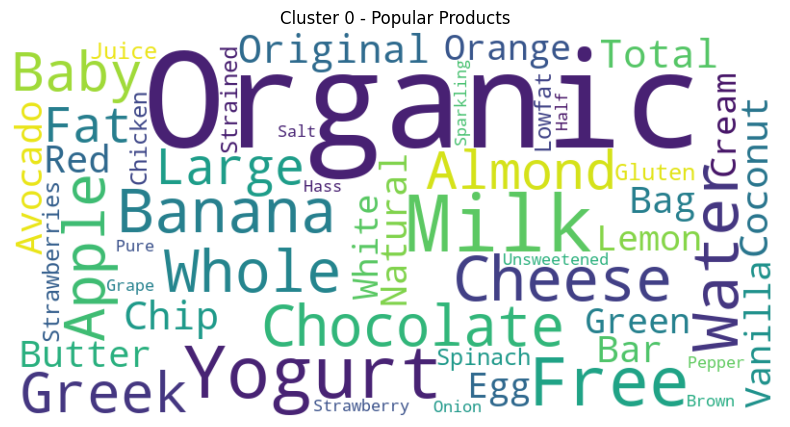

Cluster 0 - Top 15 Popular Products:
Banana                    848
Bag of Organic Bananas    728
Organic Baby Spinach      628
Organic Strawberries      498
Organic Hass Avocado      463
Limes                     368
Organic Raspberries       322
Organic Whole Milk        287
Large Lemon               280
Organic Avocado           280
Strawberries              259
Organic Zucchini          220
Organic Garlic            212
Spring Water              210
Organic Lemon             206
Name: product_name, dtype: int64



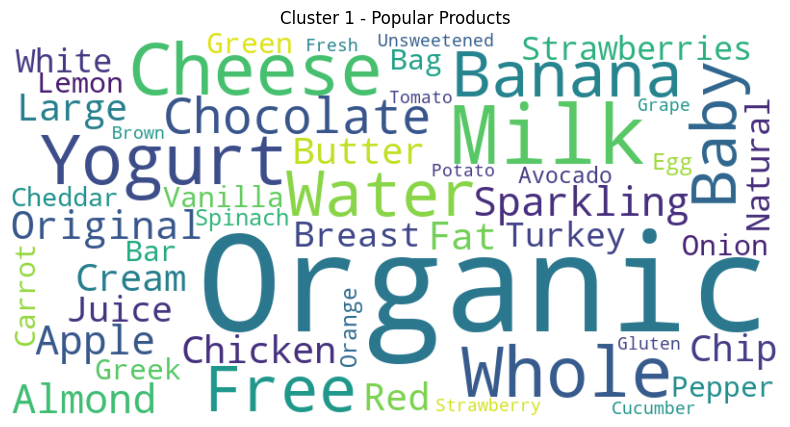

Cluster 1 - Top 15 Popular Products:
Banana                               517
Bag of Organic Bananas               375
Organic Strawberries                 251
Sparkling Water Grapefruit           220
Organic Baby Spinach                 204
Organic Avocado                      199
Large Lemon                          196
Strawberries                         179
Organic Whole Milk                   165
Organic Hass Avocado                 140
Organic Garlic                       136
Limes                                124
Organic Peeled Whole Baby Carrots    121
Cucumber Kirby                       118
Honeycrisp Apple                     116
Name: product_name, dtype: int64



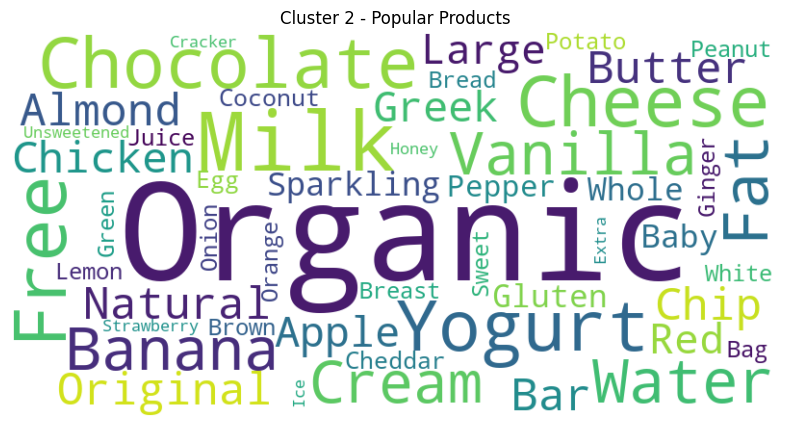

Cluster 2 - Top 15 Popular Products:
Banana                             309
Bag of Organic Bananas             164
Sparkling Natural Mineral Water    136
Organic Strawberries               128
Organic Red Bell Pepper            120
Organic Garlic                     105
Large Lemon                        103
Organic Baby Spinach                98
Strawberries                        92
Sparkling Water Grapefruit          85
Limes                               85
Organic Hass Avocado                83
Original Hummus                     80
Organic Tomato Cluster              78
Organic Whole Milk                  76
Name: product_name, dtype: int64



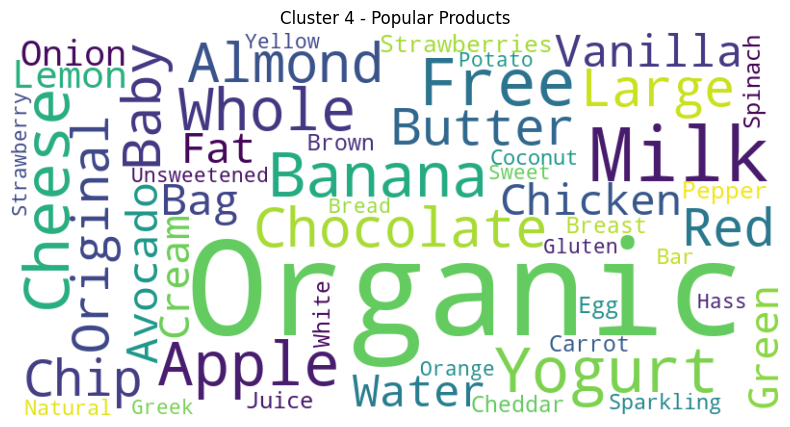

Cluster 4 - Top 15 Popular Products:
Bag of Organic Bananas                         732
Banana                                         697
Organic Strawberries                           533
Organic Baby Spinach                           435
Organic Hass Avocado                           371
Organic Avocado                                314
Organic Yellow Onion                           240
Large Lemon                                    228
Organic Raspberries                            222
Strawberries                                   214
Organic Garlic                                 207
Limes                                          195
Organic Baby Carrots                           189
Organic Whole Milk                             189
Organic Large Brown Grade AA Cage Free Eggs    184
Name: product_name, dtype: int64



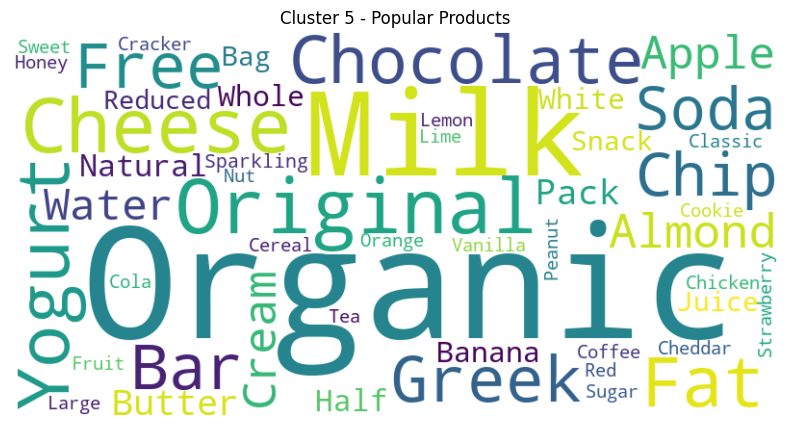

Cluster 5 - Top 15 Popular Products:
Soda                        380
Banana                      351
Fridge Pack Cola            175
Strawberries                169
Bag of Organic Bananas      167
2% Reduced Fat Milk         160
Organic Half & Half         131
Organic Fuji Apple          128
0% Greek Strained Yogurt    117
Cucumber Kirby              115
Organic Avocado             104
Cola                        101
Clementines                  96
Granny Smith Apples          95
Large Lemon                  91
Name: product_name, dtype: int64



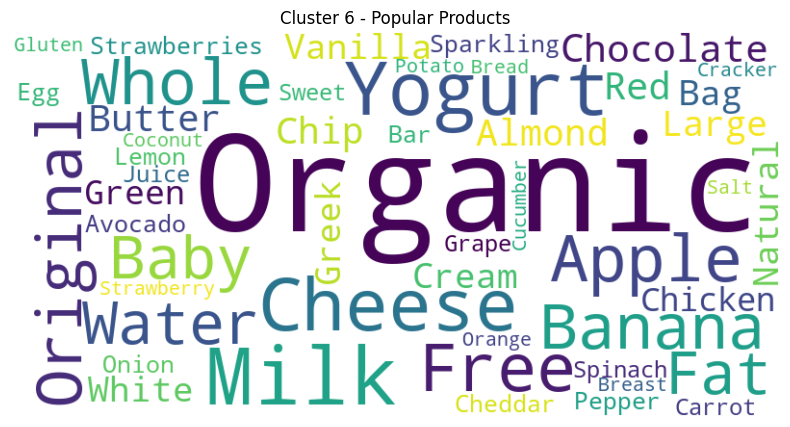

Cluster 6 - Top 15 Popular Products:
Banana                      2035
Bag of Organic Bananas      1306
Organic Strawberries        1007
Organic Baby Spinach         916
Organic Hass Avocado         847
Organic Avocado              713
Large Lemon                  589
Strawberries                 587
Limes                        505
Organic Zucchini             504
Organic Raspberries          463
Apple Honeycrisp Organic     453
Cucumber Kirby               439
Organic Yellow Onion         413
Seedless Red Grapes          403
Name: product_name, dtype: int64



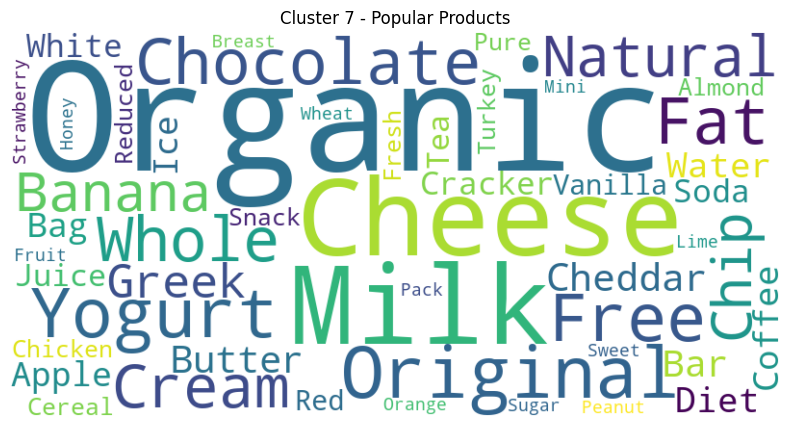

Cluster 7 - Top 15 Popular Products:
Banana                                          284
Bag of Organic Bananas                           93
Cherubs Heavenly Salad Tomatoes                  79
Organic Blackberries                             77
2% Reduced Fat Milk                              72
Organic Blueberries                              68
Organic Strawberries                             67
Limes                                            60
Whole Milk                                       58
Seedless Red Grapes                              56
100% Whole Wheat Bread                           53
Eggo Homestyle Waffles                           49
Whole Grain White Corn Salted Tortilla Chips     48
Country Potato Bread                             47
Skim Milk                                        47
Name: product_name, dtype: int64



In [158]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the products dataset
products_df = pd.read_csv("~/Downloads/products.csv")

# Take a random sample of 1% of the dataset
sample_df = reshaped_df.sample(frac=0.01, random_state=42)

# Explode the product_id_list column in the sampled DataFrame
exploded_df = sample_df.explode('product_id_list')

# Merge the exploded dataframe with the sampled products_df to retrieve product names
merged_df_product = pd.merge(exploded_df, products_df, left_on='product_id_list', right_on='product_id', how='left')

# Group the merged dataframe by cluster_kmeans and aggregate product names into a single string
grouped_cluster_df = merged_df_product.groupby('cluster_gmm')['product_name'].apply(lambda x: ' '.join(x))

# Generate word cloud for each cluster and find the top 10 popular product names
for cluster, products in grouped_cluster_df.items():
    # Count the occurrence of each product name
    product_counts = merged_df_product[merged_df_product['cluster_gmm'] == cluster]['product_name'].value_counts()
    
    # Get the top 15 most popular product names
    top_15_products = product_counts.head(15)
    
    # Generate word cloud for the products
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        collocations=False
    ).generate(products)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Cluster {cluster} - Popular Products")
    plt.axis('off')
    plt.show()
    
    # Print the top 15 most popular product names
    print(f"Cluster {cluster} - Top 15 Popular Products:")
    print(top_15_products)
    print()





We create word clouds and list top 10 most popular products for each GMM cluster

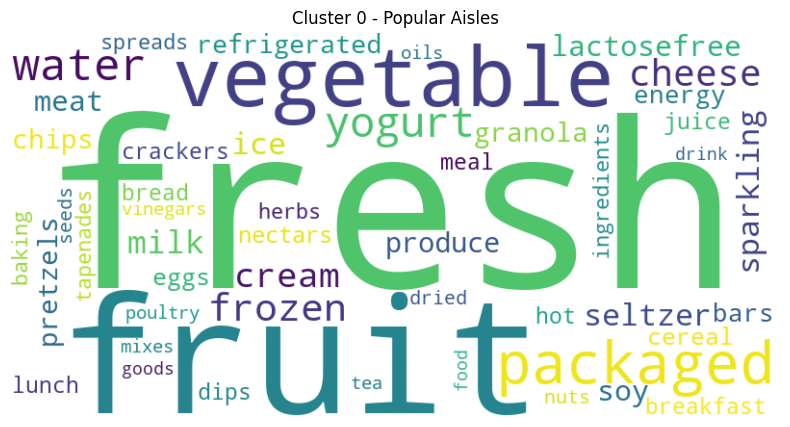

Cluster 0 - Top 10 Popular Aisles:
Aisle: fresh fruits | Count: 7063 | Percentage: 14.34%
Aisle: fresh vegetables | Count: 6108 | Percentage: 12.40%
Aisle: packaged vegetables fruits | Count: 3187 | Percentage: 6.47%
Aisle: yogurt | Count: 2737 | Percentage: 5.55%
Aisle: milk | Count: 1542 | Percentage: 3.13%
Aisle: packaged cheese | Count: 1522 | Percentage: 3.09%
Aisle: water seltzer sparkling water | Count: 1464 | Percentage: 2.97%
Aisle: soy lactosefree | Count: 1266 | Percentage: 2.57%
Aisle: chips pretzels | Count: 1127 | Percentage: 2.29%
Aisle: refrigerated | Count: 1073 | Percentage: 2.18%



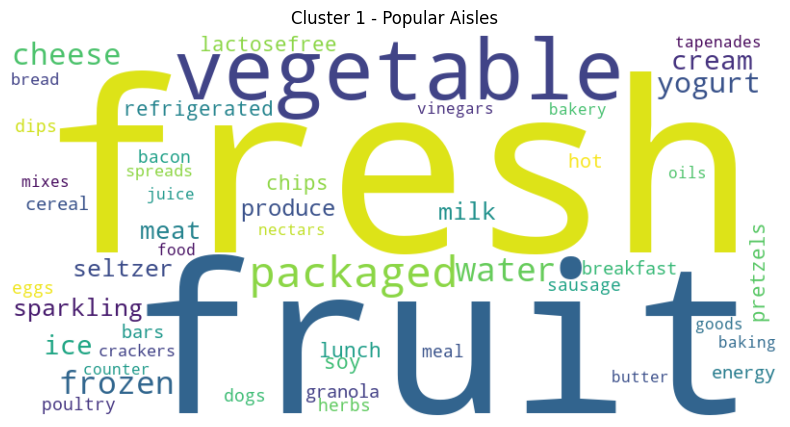

Cluster 1 - Top 10 Popular Aisles:
Aisle: fresh fruits | Count: 3713 | Percentage: 13.00%
Aisle: fresh vegetables | Count: 3537 | Percentage: 12.38%
Aisle: packaged vegetables fruits | Count: 1878 | Percentage: 6.57%
Aisle: yogurt | Count: 1357 | Percentage: 4.75%
Aisle: packaged cheese | Count: 1085 | Percentage: 3.80%
Aisle: water seltzer sparkling water | Count: 986 | Percentage: 3.45%
Aisle: milk | Count: 974 | Percentage: 3.41%
Aisle: chips pretzels | Count: 654 | Percentage: 2.29%
Aisle: lunch meat | Count: 652 | Percentage: 2.28%
Aisle: refrigerated | Count: 634 | Percentage: 2.22%



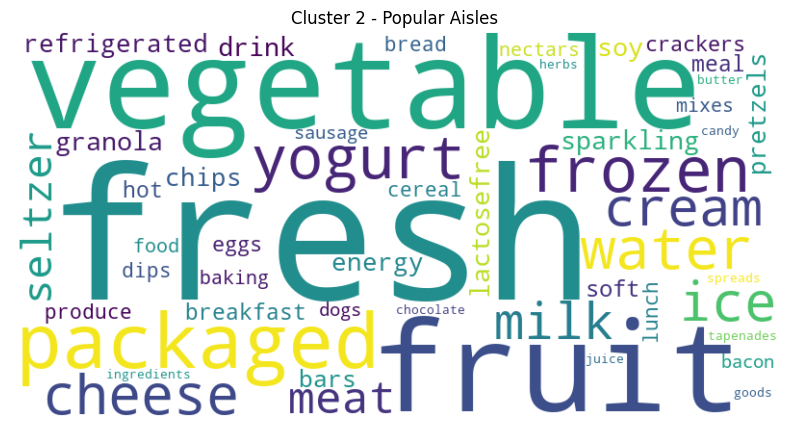

Cluster 2 - Top 10 Popular Aisles:
Aisle: fresh vegetables | Count: 2021 | Percentage: 11.06%
Aisle: fresh fruits | Count: 1794 | Percentage: 9.82%
Aisle: yogurt | Count: 1006 | Percentage: 5.51%
Aisle: packaged vegetables fruits | Count: 975 | Percentage: 5.34%
Aisle: milk | Count: 703 | Percentage: 3.85%
Aisle: packaged cheese | Count: 649 | Percentage: 3.55%
Aisle: water seltzer sparkling water | Count: 471 | Percentage: 2.58%
Aisle: soy lactosefree | Count: 458 | Percentage: 2.51%
Aisle: chips pretzels | Count: 436 | Percentage: 2.39%
Aisle: refrigerated | Count: 432 | Percentage: 2.36%



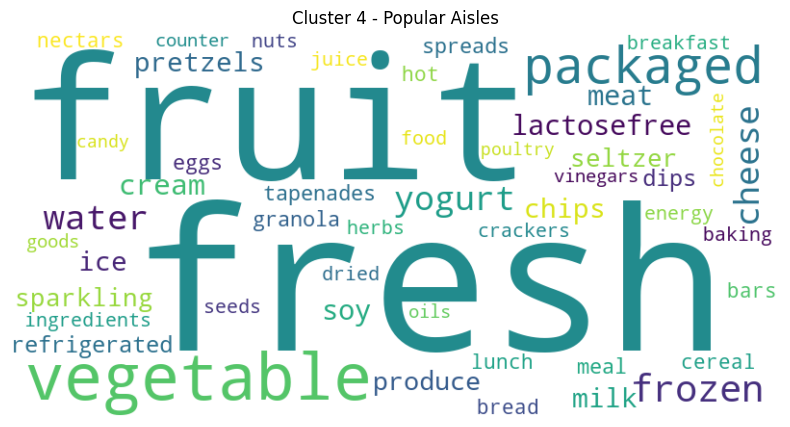

Cluster 4 - Top 10 Popular Aisles:
Aisle: fresh fruits | Count: 5895 | Percentage: 13.51%
Aisle: fresh vegetables | Count: 5799 | Percentage: 13.29%
Aisle: packaged vegetables fruits | Count: 2814 | Percentage: 6.45%
Aisle: yogurt | Count: 2008 | Percentage: 4.60%
Aisle: packaged cheese | Count: 1516 | Percentage: 3.47%
Aisle: soy lactosefree | Count: 1334 | Percentage: 3.06%
Aisle: chips pretzels | Count: 1263 | Percentage: 2.90%
Aisle: milk | Count: 1219 | Percentage: 2.79%
Aisle: water seltzer sparkling water | Count: 1046 | Percentage: 2.40%
Aisle: refrigerated | Count: 857 | Percentage: 1.96%



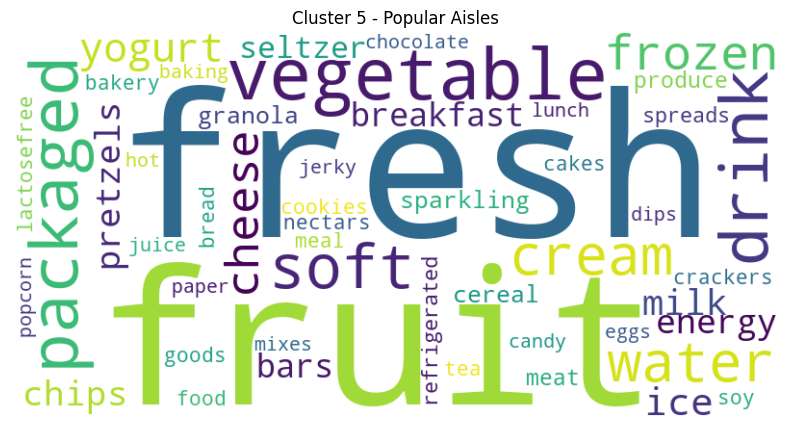

Cluster 5 - Top 10 Popular Aisles:
Aisle: fresh fruits | Count: 2126 | Percentage: 8.80%
Aisle: soft drinks | Count: 1533 | Percentage: 6.35%
Aisle: fresh vegetables | Count: 1215 | Percentage: 5.03%
Aisle: yogurt | Count: 1035 | Percentage: 4.29%
Aisle: milk | Count: 808 | Percentage: 3.35%
Aisle: packaged vegetables fruits | Count: 799 | Percentage: 3.31%
Aisle: chips pretzels | Count: 767 | Percentage: 3.18%
Aisle: packaged cheese | Count: 704 | Percentage: 2.91%
Aisle: water seltzer sparkling water | Count: 641 | Percentage: 2.65%
Aisle: cereal | Count: 544 | Percentage: 2.25%



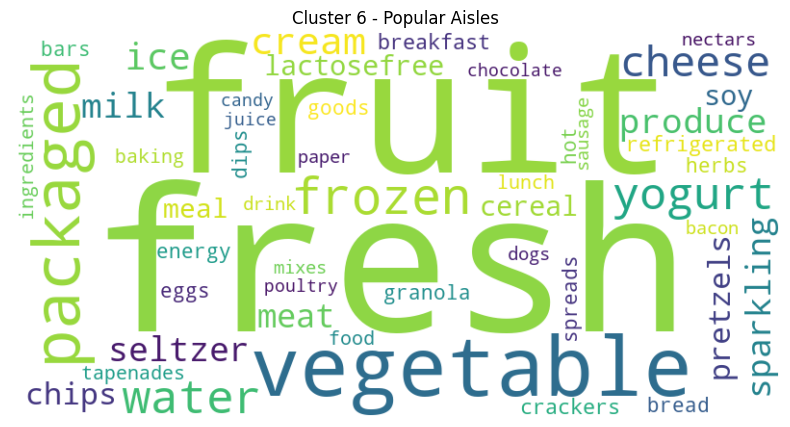

Cluster 6 - Top 10 Popular Aisles:
Aisle: fresh fruits | Count: 14973 | Percentage: 13.53%
Aisle: fresh vegetables | Count: 13748 | Percentage: 12.42%
Aisle: packaged vegetables fruits | Count: 7123 | Percentage: 6.43%
Aisle: yogurt | Count: 5807 | Percentage: 5.25%
Aisle: packaged cheese | Count: 3629 | Percentage: 3.28%
Aisle: milk | Count: 3265 | Percentage: 2.95%
Aisle: water seltzer sparkling water | Count: 3077 | Percentage: 2.78%
Aisle: chips pretzels | Count: 2629 | Percentage: 2.37%
Aisle: frozen produce | Count: 2165 | Percentage: 1.96%
Aisle: soy lactosefree | Count: 2152 | Percentage: 1.94%



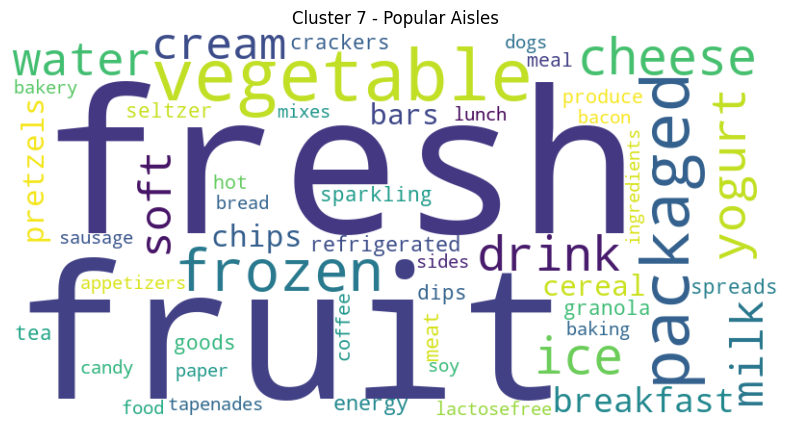

Cluster 7 - Top 10 Popular Aisles:
Aisle: fresh fruits | Count: 1306 | Percentage: 8.33%
Aisle: fresh vegetables | Count: 920 | Percentage: 5.87%
Aisle: yogurt | Count: 747 | Percentage: 4.76%
Aisle: packaged vegetables fruits | Count: 641 | Percentage: 4.09%
Aisle: milk | Count: 632 | Percentage: 4.03%
Aisle: soft drinks | Count: 628 | Percentage: 4.00%
Aisle: packaged cheese | Count: 616 | Percentage: 3.93%
Aisle: chips pretzels | Count: 427 | Percentage: 2.72%
Aisle: ice cream ice | Count: 393 | Percentage: 2.51%
Aisle: refrigerated | Count: 370 | Percentage: 2.36%



In [159]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the products and aisles datasets
aisles_df = pd.read_csv("~/Downloads/aisles.csv")

# Take a random sample of 1% of the dataset
sample_df = reshaped_df.sample(frac=0.01, random_state=42)

# Explode the aisle_id_list column to separate rows
exploded_df = sample_df.explode('aisle_id_list')

# Merge the exploded dataframe with aisles_df to retrieve aisle names
merged_df_aisle = pd.merge(exploded_df, aisles_df, left_on='aisle_id_list', right_on='aisle_id', how='left')

# Group the merged dataframe by cluster_gmm and aggregate aisle names into a single string
grouped_cluster_df = merged_df_aisle.groupby('cluster_gmm')['aisle'].apply(lambda x: ' '.join(x))

# Generate word cloud for each cluster and find the top 10 popular aisle names
for cluster, aisles in grouped_cluster_df.items():
    # Count the occurrence of each aisle name
    aisle_counts = merged_df_aisle[merged_df_aisle['cluster_gmm'] == cluster]['aisle'].value_counts()
    
    # Get the top 10 most popular aisle names
    top_10_aisles = aisle_counts.head(10)
    
    # Calculate the percentage of products in each aisle
    total_products = len(merged_df_aisle[merged_df_aisle['cluster_gmm'] == cluster])
    aisle_percentages = aisle_counts / total_products * 100
    
    # Generate word cloud for the aisles
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        collocations=False
    ).generate(aisles)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Cluster {cluster} - Popular Aisles")
    plt.axis('off')
    plt.show()
    
    # Print the top 10 most popular aisles with their percentage of products
    print(f"Cluster {cluster} - Top 10 Popular Aisles:")
    for aisle, count in top_10_aisles.items():
        percentage = aisle_percentages[aisle]
        print(f"Aisle: {aisle} | Count: {count} | Percentage: {percentage:.2f}%")
    print()


Latent customers: we notice that cluster 5 is an interesting one. A first analysis of the clusters confirm the initial hypothesis that: fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, packaged cheese, milk, water seltzer sparkling water, chips pretzels are products which are genereically bought by the majority of the customers. However, in cluster 5 the most bought product is soda. Let's explore the buying habits of people from cluster 5.

In [160]:
# Cluster 5 - Top 25 Products Bought
cluster_5_products = merged_df_product[merged_df_product['cluster_gmm'] == 5]['product_name'].value_counts().head(25)
total_products_cluster_5 = len(merged_df_product[merged_df_product['cluster_gmm'] == 5])
cluster_5_product_percentages = cluster_5_products / total_products_cluster_5 * 100

print("Cluster 5 - Top 25 Products Bought:")
for product, count in cluster_5_products.items():
    percentage = cluster_5_product_percentages[product]
    print(f"Product: {product} | Count: {count} | Percentage: {percentage:.2f}%")

print()

# Cluster 5 - Top 15 Aisles
cluster_5_aisles = merged_df_aisle[merged_df_aisle['cluster_gmm'] == 5]['aisle'].value_counts().head(15)
total_aisles_cluster_5 = len(merged_df_aisle[merged_df_aisle['cluster_gmm'] == 5])
cluster_5_aisle_percentages = cluster_5_aisles / total_aisles_cluster_5 * 100

print("Cluster 5 - Top 15 Aisles:")
for aisle, count in cluster_5_aisles.items():
    percentage = cluster_5_aisle_percentages[aisle]
    print(f"Aisle: {aisle} | Count: {count} | Percentage: {percentage:.2f}%")


Cluster 5 - Top 25 Products Bought:
Product: Soda | Count: 380 | Percentage: 1.57%
Product: Banana | Count: 351 | Percentage: 1.45%
Product: Fridge Pack Cola | Count: 175 | Percentage: 0.72%
Product: Strawberries | Count: 169 | Percentage: 0.70%
Product: Bag of Organic Bananas | Count: 167 | Percentage: 0.69%
Product: 2% Reduced Fat Milk | Count: 160 | Percentage: 0.66%
Product: Organic Half & Half | Count: 131 | Percentage: 0.54%
Product: Organic Fuji Apple | Count: 128 | Percentage: 0.53%
Product: 0% Greek Strained Yogurt | Count: 117 | Percentage: 0.48%
Product: Cucumber Kirby | Count: 115 | Percentage: 0.48%
Product: Organic Avocado | Count: 104 | Percentage: 0.43%
Product: Cola | Count: 101 | Percentage: 0.42%
Product: Clementines | Count: 96 | Percentage: 0.40%
Product: Granny Smith Apples | Count: 95 | Percentage: 0.39%
Product: Large Lemon | Count: 91 | Percentage: 0.38%
Product: Limes | Count: 89 | Percentage: 0.37%
Product: Total 0% Greek Yogurt | Count: 87 | Percentage: 0.36